# Model Training
In this notebook, we will train our VAE model. This involves:

1. Encoder
2. Decoder
3. Full Model

## Importing Packages
We will be using Keras to build and train our VAE

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib notebook
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import h5py

# import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
import mdn

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

from IPython import display
import numpy as np
import pandas as pd
from sklearn import preprocessing
from pickle import dump, load

from matplotlib.ticker import FormatStrFormatter
from IPython.display import SVG

## Definition of Constants
Hyper parameters and constants will all be located here for ease of adjustments

In [2]:
categorical_dim = 11
categorical_map = {0:0, 0.5:1, 1: 2, 1.5:3, 2:4, 2.5:5, 3:6, 3.5:7, 4:8, 4.5:9, 5:10}
reverse_categorical_map = {0:0, 1:0.5, 2:1, 3:1.5, 4:2, 5:2.5, 6:3, 7:3.5, 8:4, 9:4.5, 10:5}
continuous_dim = 3
binary_dim = 1
original_dim = binary_dim + continuous_dim + categorical_dim
intermediate_dim_1 = 50
intermediate_dim_2 = 50
latent_dim = 4
batch_size = 100
epochs = 50
epsilon_std = 1.0

## Constants for the Mixture layer
N_HIDDEN = 15  # number of hidden units in the Dense layer
N_MIXES = 10  # number of mixture components
OUTPUT_DIMS = 2  # number of real-values predicted by each mixture component

# Model File Paths
full_model_file = "./model/vae_full_model.json"
full_model_weights = "./model/vae_full_model.h5"
encoder_file = "./model/vae_encoder.json"
encoder_weights = "./model/vae_encoder.h5"
decoder_file = './model/vae_decoder.json'
decoder_weights = './model/vae_decoder.h5'
z_meta_file = './model/z_meta.npy'

## Building the Model
We have to write our own custom layer and custom loss function as these are not supported on Keras natively. There are a few things to be done:

1. Custom KLDivergence Layer
2. Custom Loss Functions
3. Building the Model

### Custom Loss Functions
As the yelp dataset contains binary, categorical as well as continuous data, we will build 3 custom loss functions.

#### Binary Loss Function

In [3]:
def binary_loss(y_true, y_pred):
	# input dimension is (batchsize, 1)
    return K.binary_crossentropy(y_true, y_pred) # the dimension of return value is (batchsize , 1)

#### Categorical Loss Function

In [4]:
def categorical_loss(y_true, y_pred):
	# input dimension is (batchsize, number of categories)
  return K.categorical_crossentropy(y_true, y_pred) # the dimension of return value is (batchsize , 1)

#### Continuous Loss Function

In [5]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis) # return a tensor of shape (batch_size, 1)

# Added a postfix because now we also have poisson as a distribution
def continuous_loss_gaussian(y_true, y_pred):
	# need to return log probability for continuous gaussian loss.
	# will get a (batchsize, 6 continuous variable input) where 3 of the 6 represents mu and the others logvar
	# y_true will be (batchsize, 3)
  mu, logvar = tf.split(y_pred, num_or_size_splits = 2, axis = 1)
  return -1 * log_normal_pdf(y_true, mu, logvar) 

def continuous_loss_poisson(y_true, y_pred):
	# need to return log probability for continuous poisson loss.
	# will get a (batchsize, 6 continuous variable input) where 3 of the 6 represents mu and the others logvar
	# y_true will be (batchsize, 3)
  return tf.nn.log_poisson_loss(y_true, y_pred)

### Model Architecture
- tanh/sigmoid is used because Relu resulted in loss going to infinity
- going to delete review_log_var and review_mu since we are trying out the Poission distribution which only takes 1 parameter.

In [7]:
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions


input_shape = (original_dim,)
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dim), scale=1), reinterpreted_batch_ndims=1)

## Encoder
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape, name = 'input_x'),
    tfkl.Dense(intermediate_dim_1, activation='tanh', name='hidden_enc_1'),
    tfkl.Dense(intermediate_dim_2, activation='tanh', name='hidden_enc_2'),
    tfkl.Dense(tfpl.IndependentNormal.params_size(latent_dim), activation=None, name = 'z_probability_distribution'),
])

sampler = tfk.Sequential([
    tfkl.InputLayer(input_shape=(tfpl.IndependentNormal.params_size(latent_dim), ), name = 'input_z_params'),
    tfpl.IndependentNormal( latent_dim, name = 'sample_layer'),
    tfpl.KLDivergenceAddLoss(
        tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim))),
])

decode_1 = tfkl.Dense(intermediate_dim_2, activation='tanh', name='hidden_dec_2')
h_dec = decode_1(sampler(encoder.outputs[0]))

decode_2 = tfkl.Dense(intermediate_dim_1, activation='tanh', name='hidden_dec_1')
h_dec = decode_2(h_dec)

x_pred_coordinates_mdn_layer = mdn.MDN(OUTPUT_DIMS, N_MIXES, name = 'x_pred_coordinates_mdn_layer')
x_pred_coordinates = x_pred_coordinates_mdn_layer(h_dec)


## This outputs the lambda require for poisson distribution and thats all that we need
x_pred_review_log_lambda_layer = tfkl.Dense(1,name = 'x_pred_review_log_lambda_layer')
x_pred_review = x_pred_review_log_lambda_layer(h_dec)

x_pred_binary_layer = tfkl.Dense(binary_dim, activation='sigmoid', name='x_pred_binary')
x_pred_binary = x_pred_binary_layer(h_dec) # binary cross entropy

x_pred_categorical_layer = tfkl.Dense(categorical_dim, name='x_pred_categorical')
x_pred_categorical_layer_activation = tfkl.Activation(tf.nn.softmax)
x_pred_categorical = x_pred_categorical_layer(h_dec) # categorical cross entropy
x_pred_categorical = x_pred_categorical_layer_activation(x_pred_categorical)

vae = tfk.Model(inputs=encoder.inputs, outputs=[x_pred_binary, x_pred_categorical, x_pred_review, x_pred_coordinates])

### Visualizing the Model

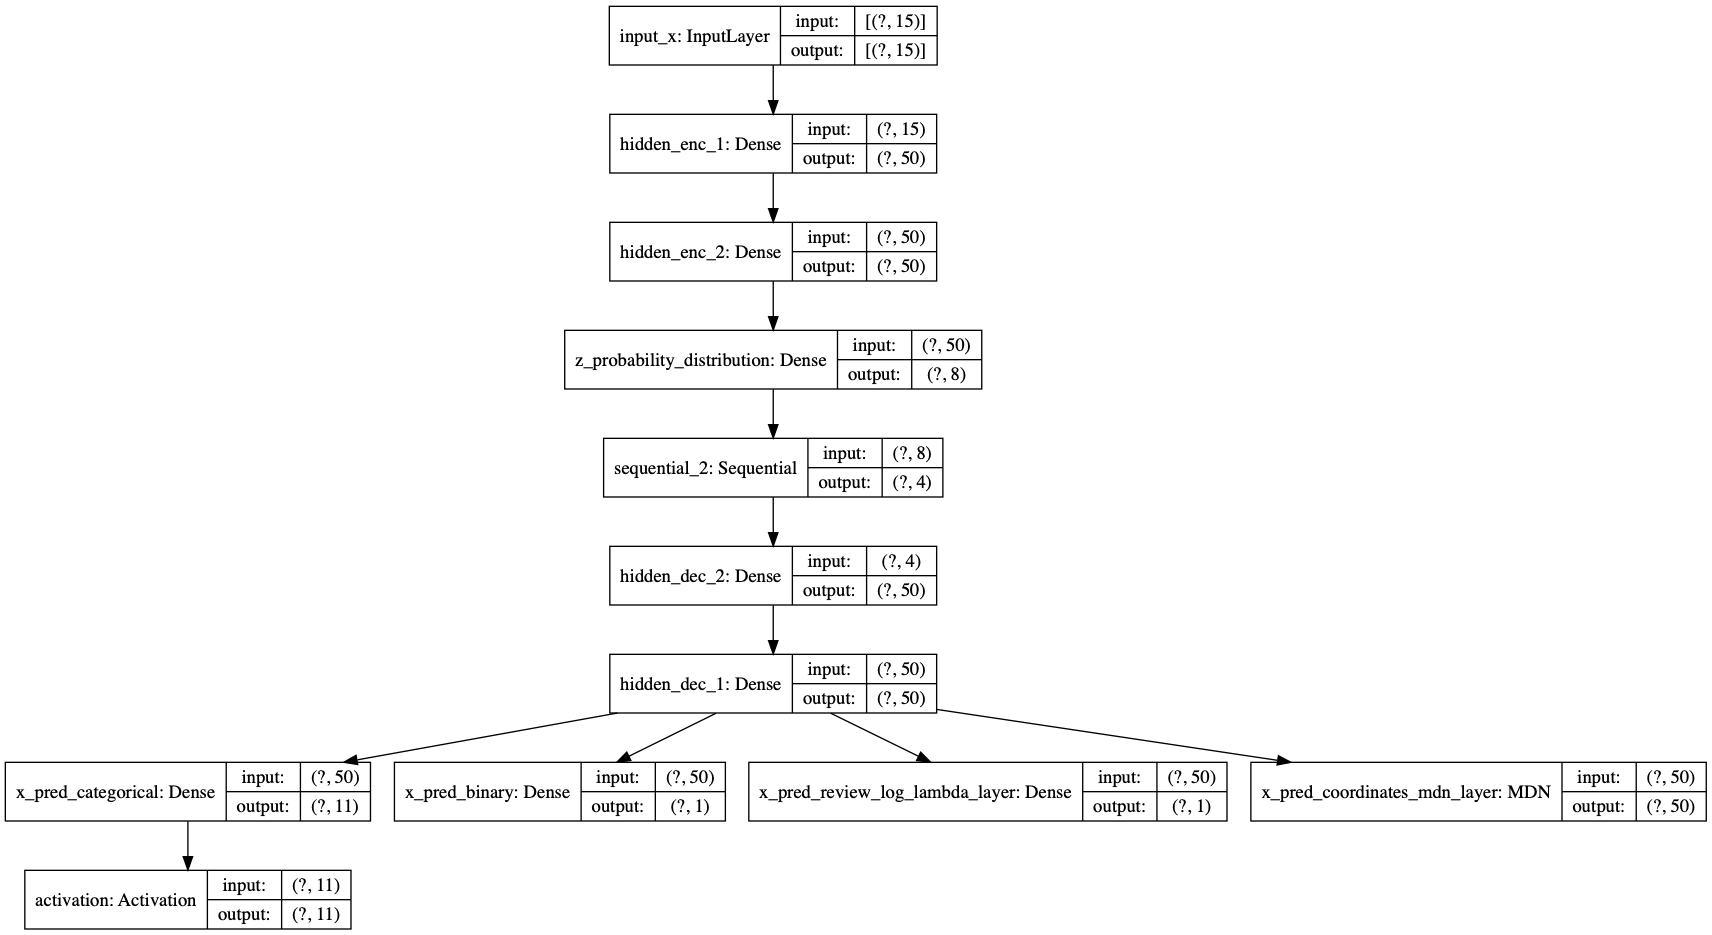

In [8]:
tf.keras.utils.plot_model(
    vae, to_file='./description/vae_full_model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

### Compiling Model and Setting Parameters

In [9]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001)
vae.compile(optimizer=optimizer, loss=[binary_loss, categorical_loss, continuous_loss_poisson, mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES)], loss_weights=[1, 1, 1, 1])



Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


### Alternatively, you can upload the weights which was trained during the previous time

In [103]:
vae.load_weights(full_model_weights)

ValueError: Shapes (50, 11) and (50, 1) are incompatible

In [10]:
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
hidden_enc_1 (Dense)            (None, 50)           800         input_x[0][0]                    
__________________________________________________________________________________________________
hidden_enc_2 (Dense)            (None, 50)           2550        hidden_enc_1[0][0]               
__________________________________________________________________________________________________
z_probability_distribution (Den (None, 8)            408         hidden_enc_2[0][0]               
______________________________________________________________________________________________

## Data Loading and Preprocessing

### Converting Coordinates to 2D Euclidean space (mercator)

In [11]:
import math
def lonlat2meters(lon, lat):
    semimajoraxis = 6378137.0
    east = lon * 0.017453292519943295
    north = lat * 0.017453292519943295
    t = math.sin(north)
    return semimajoraxis * east, 3189068.5 * math.log((1 + t) / (1 - t))

def meters2lonlat(x, y):
    semimajoraxis = 6378137.0
    lon = x / semimajoraxis / 0.017453292519943295
    t = math.exp(y / 3189068.5)
    lat = math.asin((t - 1) / (t + 1)) / 0.017453292519943295
    return lon, lat

In [12]:
dataset = np.genfromtxt('../../datasets/yelp_business.csv',delimiter=',',skip_header=1)
dataset = dataset[~np.isnan(dataset).any(axis=1)]
test_set, train_set = np.split(dataset,[1], axis = 0)

def format_data(dataset, scaler_to_use=None ,save_scaler=True):
    # handling the categorical variables
    coordinates, ratings, reviews, is_opens = np.split(dataset, [2, 3, 4], axis = 1)
    one_hot_array = np.zeros((ratings.shape[0], categorical_dim))

    for i, r in enumerate(ratings):
        one_hot_array[i][categorical_map[r[0]]] = 1
    
    # handling coordinates
    for i, c in enumerate(coordinates):
        lon = coordinates[i][1]
        lat = coordinates[i][0]
        x, y = lonlat2meters(lon, lat)
        coordinates[i][1] = x
        coordinates[i][0] = y
    
    if scaler_to_use is None:
        scaler_to_use = preprocessing.StandardScaler()
        scaler_to_use.fit(coordinates)
    
    coordinates = scaler_to_use.transform(coordinates)
    
    if save_scaler:
        dump(scaler_to_use, open('./model/standard_scaler.pkl', 'wb'))
    
    dataset = np.concatenate((coordinates, reviews, is_opens, one_hot_array), axis = 1)

    # creating the labels
    coordinates_labels = coordinates
    review_labels = reviews
    categorical_labels = one_hot_array
    binary_labels = is_opens
    return dataset, coordinates_labels, review_labels, categorical_labels, binary_labels

train_dataset, train_coordinates_labels, train_review_labels, train_categorical_labels, train_binary_labels = format_data(train_set)

## Open scaler
scaler = load(open('./model/standard_scaler.pkl', 'rb'))
test_dataset, test_coordinates_labels, test_review_labels, test_categorical_labels, test_binary_labels = format_data(test_set, scaler, False)



### Distribution of Review_Count

<IPython.core.display.Javascript object>


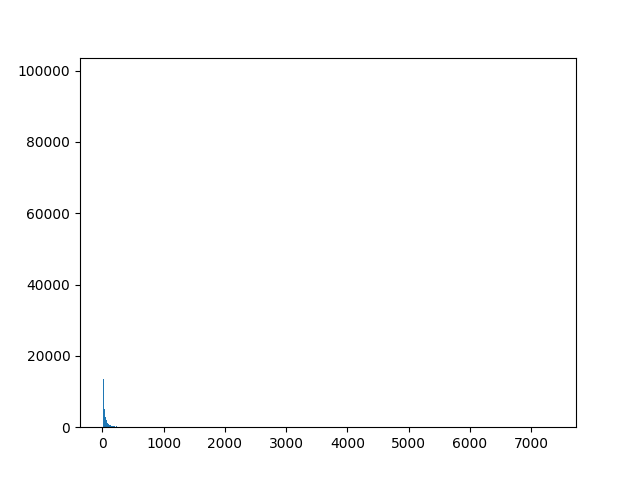

In [13]:
import matplotlib.pyplot as plt
plt.hist(train_review_labels, 1000)
plt.show()

## Training the Model

In [15]:
vae.fit(train_dataset , [train_binary_labels, train_categorical_labels, train_review_labels, train_coordinates_labels], shuffle = True, epochs = 10, batch_size = batch_size, validation_data=(test_dataset , [test_binary_labels, test_categorical_labels, test_review_labels, test_coordinates_labels]))






Train on 174565 samples, validate on 1 samples
Epoch 1/10
174565/174565 [==============================] - 13s 76us/sample - loss: -108.4673 - x_pred_binary_loss: 0.4378 - activation_loss: 1.8987 - x_pred_review_log_lambda_layer_loss: -108.9451 - x_pred_coordinates_mdn_layer_loss: -3.7326 - val_loss: -47.6742 - val_x_pred_binary_loss: 0.1698 - val_activation_loss: 1.3667 - val_x_pred_review_log_lambda_layer_loss: -45.8428 - val_x_pred_coordinates_mdn_layer_loss: -4.9154
Epoch 2/10
174565/174565 [==============================] - 10s 60us/sample - loss: -108.4001 - x_pred_binary_loss: 0.4379 - activation_loss: 1.8982 - x_pred_review_log_lambda_layer_loss: -108.8430 - x_pred_coordinates_mdn_layer_loss: -3.7262 - val_loss: -46.9388 - val_x_pred_binary_loss: 0.1463 - val_activation_loss: 2.0329 - val_x_pred_review_log_lambda_layer_loss: -45.2950 - val_x_pred_coordinates_mdn_layer_loss: -5.5544
Epoch 3/10
174565/174565 [==============================] - 11s 61us/sample - loss: -108.3980 - x

## Building the Decoder

In [16]:
decode_input = Input(shape=(latent_dim, ), name = 'decode_input')
decode_layer_1 = decode_1(decode_input)
decode_layer_2 = decode_2(decode_layer_1)

decode_x_pred_coordinates=x_pred_coordinates_mdn_layer(decode_layer_2)

decode_x_pred_review = x_pred_review_log_lambda_layer(decode_layer_2)

decode_x_pred_binary = x_pred_binary_layer(decode_layer_2) # binary cross entropy
decode_x_pred_categorical = x_pred_categorical_layer(decode_layer_2) # categorical cross entropy
decode_x_pred_categorical = x_pred_categorical_layer_activation(decode_x_pred_categorical)


decoder = Model(decode_input, [decode_x_pred_coordinates, decode_x_pred_review, decode_x_pred_categorical, decode_x_pred_binary])

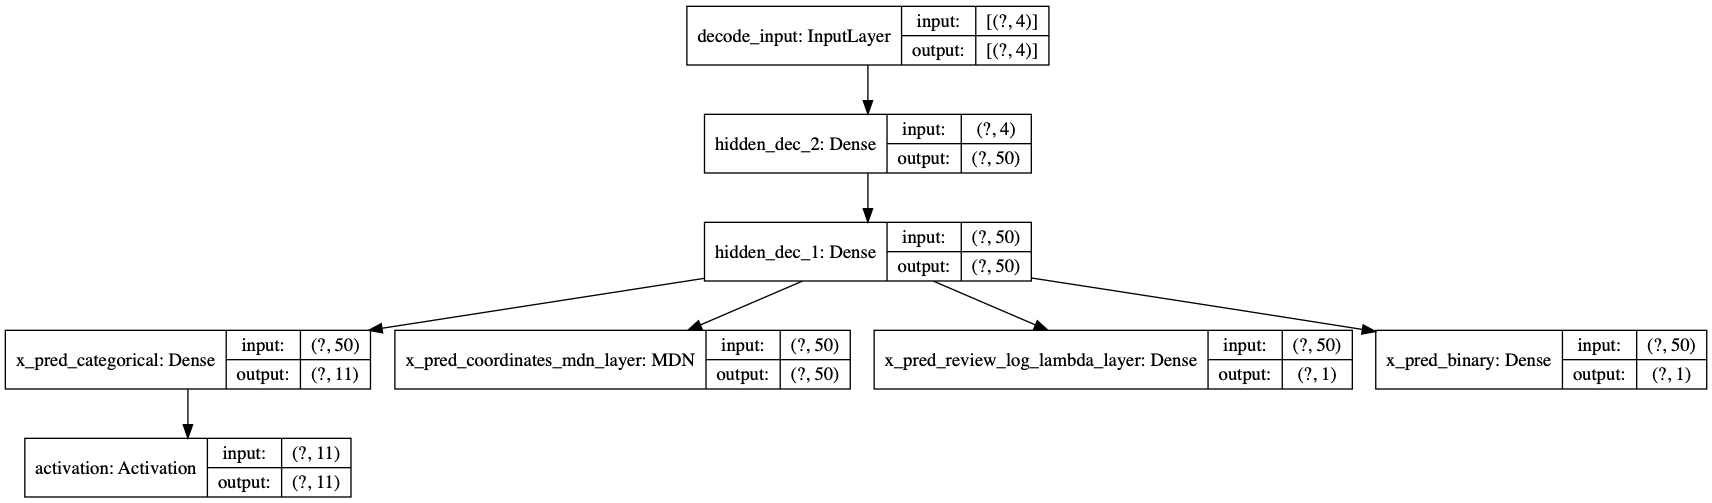

In [17]:
tf.keras.utils.plot_model(
    decoder, to_file='./description/vae_decoder.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

### Saving the Models and Metadata
#### Saving Models (Actually, only the decoder matter)

In [20]:
# model_json = vae.to_json()
# with open(full_model_file, "w") as json_file:
#     json_file.write(model_json)
vae.save_weights(full_model_weights)
print("Saved model to disk")

# encoder = Model(x, [z_mu, z_log_var])
model_json = encoder.to_json()
with open(encoder_file, "w") as json_file:
    json_file.write(model_json)
encoder.save_weights(encoder_weights)
print("Saved model to disk")

model_json = decoder.to_json()
with open(decoder_file, "w") as json_file:
    json_file.write(model_json)
decoder.save_weights(decoder_weights)
print("Saved model to disk")


Saved model to disk
Saved model to disk
Saved model to disk


#### Generating and Saving Metadata

In [21]:
vae_sample = train_dataset[np.random.choice(len(train_dataset), size=10000, replace=False)]
z_meta = encoder.predict(vae_sample, batch_size=batch_size)

np.save('./model/z_meta.npy', z_meta)

### Generating some Samples for Testing
#### Functions for data generation

In [22]:
reverse_categorical_map = {0:0, 1:0.5, 2:1, 3:1.5, 4:2, 5:2.5, 6:3, 7:3.5, 8:4, 9:4.5, 10:5}
def sample(decoder, sampler, input_z_params,samples_per_z=1):
    multiplied_input_z_params = np.repeat(input_z_params, samples_per_z, axis=0)
    z = sampler.predict(multiplied_input_z_params)
    predictions = decoder.predict(z, batch_size = None, steps = 1)
    return reconstruct(predictions)
    
def reconstruct(predictions):
    coordinates, review, categorical, binary = predictions
    print(categorical.dtype)
    # coordinates handled here
    print(coordinates.shape)
    coordinates_data = np.apply_along_axis(mdn.sample_from_output, 1, coordinates, OUTPUT_DIMS, N_MIXES, temp=1.0)
    coordinates_data = np.squeeze(coordinates_data, axis=1)
    scaler = load(open('./model/standard_scaler.pkl', 'rb'))
    coordinates_data = scaler.inverse_transform(coordinates_data)
    print(coordinates_data.shape)
    
    for i, c in enumerate(coordinates_data):
        x = coordinates_data[i][1]
        y = coordinates_data[i][0]
        lon, lat = meters2lonlat(x, y)
        coordinates_data[i][1] = lon
        coordinates_data[i][0] = lat
    
    for i, c in enumerate(coordinates_data):
        if c[0] > 180.0:
            coordinates_data[i][0]= 180.0
        if c[0] < -180.0:
            coordinates_data[i][0]= -180.0
        if c[1] > 180.0:
            coordinates_data[i][1]= 180.0
        if c[1] < -180.0:
            coordinates_data[i][1]= -180.0
    
    ## review_count handled here
    exp_log_review = np.exp(review)
    review_data = np.random.poisson(lam=exp_log_review, size = review.shape)
    for i, r in enumerate(review_data):
        if r[0] < 0:
            review_data[i][0] = 0
        review_data[i][0] = float(int(review_data[i][0]))
#     for c in categorical:
#         if np.sum(c, dtype=np.float16) > 1.0:
#             print(c, np.sum(c, dtype=np.float16))
    
    categorical = np.apply_along_axis(lambda t : np.random.multinomial(1,t), -1, categorical)
    categorical = np.apply_along_axis(lambda t : np.argmax(t), -1, categorical)
    categorical = np.expand_dims(categorical, axis = -1)
    categorical_data = np.apply_along_axis(lambda t : float(reverse_categorical_map[t[0]]), -1, categorical)
    categorical_data = np.expand_dims(categorical_data, axis = -1)
    binary_data = np.apply_along_axis(lambda t: np.random.binomial(1, t), -1, binary)
#     coordinates, reviews = np.split(continuous_data, indices_or_sections=[2], axis = 1)
    return np.concatenate([coordinates_data, categorical_data, review_data, binary_data], axis = 1)
    

def reparameterize(input_mu, input_log_var, eps):
    sigma = np.exp(0.5*input_log_var)
    return eps*sigma + input_mu

### Generating Samples
Make use of the funciton sample to generate samples with our model. U need to supply an array of mu and their respective log var in a separate array to do that. 

In [23]:
vae_samples = sample(decoder, sampler, z_meta)

# # Saving the samples in a separate file
file_name = './samples/vae_10_sample_' + str(len(z_meta))+'_times_'+ str(len(vae_samples)//len(z_meta)) + '.csv'
np.savetxt(file_name, vae_samples, delimiter = ',', header='latitude,longitude,stars,review_count,is_open')

float32
(10000, 50)
(10000, 2)


In [36]:
vae_samples[1:10]

array([[  33.35861327, -111.90751038,    5.        ,   10.        ,
           0.        ],
       [  43.83389651,  -79.19158273,    3.5       ,    6.        ,
           1.        ],
       [  35.66103766, -114.99582363,    5.        ,    8.        ,
           1.        ],
       [  43.55067007,  -89.01482954,    3.        ,    6.        ,
           1.        ],
       [  41.60122171,  -81.01335794,    2.5       ,    9.        ,
           0.        ],
       [  43.68811365,  -79.59064075,    3.        ,   33.        ,
           1.        ],
       [  36.01870616, -115.05904077,    3.        ,   12.        ,
           1.        ],
       [  35.64311011, -114.94561413,    4.5       ,    7.        ,
           1.        ],
       [  33.37984217, -112.18428434,    5.        ,    3.        ,
           1.        ]])